<a href="https://colab.research.google.com/github/2002sahapriya/SYDE552-Final-Project/blob/master/create-datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Install the required libraries

- keras
- dlib
- OpenCV
- tensorflow
- matplotlib

In [1]:
!pip install dlib opencv-python-headless

In [2]:
import os
import urllib.request
from zipfile import ZipFile
import tarfile
import cv2
import dlib
import numpy as np
import matplotlib.pyplot as plt
import bz2
import shutil

# Step 1: Setup and Downloading the Dataset

This part involves downloading the LFW dataset and setting up the environment.

In [3]:
# Function to download and extract the dataset
def download_and_extract(dataset_url, download_path='datasets/normal_face.tgz', extract_path='datasets/normal_faces', remove_file = True):
    if not os.path.exists(extract_path):
        os.makedirs(os.path.dirname(download_path), exist_ok = True)
        print("Downloading dataset...")
        urllib.request.urlretrieve(dataset_url, download_path)
        print("Download complete.")

        # Extract the zip file
        print("Extracting dataset...")
        with tarfile.open(download_path, 'r:gz') as tar:
            tar.extractall(path=os.path.dirname(extract_path))
        print("Extraction complete.")

        # Optionally, remove the zip file
        if remove_file:
            os.remove(download_path)
            print('Tar.gz file removed.')

        print("Dataset ready.")
    else:
        print("Dataset already downloaded and extracted.")

In [4]:
# URL of the LFW dataset
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw.tgz'
# Set download to false if the download is not needed
download = True
if download:
    download_and_extract(dataset_url = lfw_url, remove_file = False)
    download = False

Download complete.
Extracting dataset...
Extraction complete.
Dataset ready.


In [5]:
# Function to load and display images from the dataset
def load_and_display_images(base_path, num_images_to_display=3):
    # Initialize an empty list to hold the image paths
    image_paths = []

    # Walk through the directory tree to find image files
    for root, dirs, files in os.walk(base_path):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Append the full path of each image to the list
                image_paths.append(os.path.join(root, file))

    # Display the first few images as specified by num_images_to_display
    plt.figure(figsize=(15, 5))
    for i, image_path in enumerate(image_paths[:num_images_to_display]):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        plt.subplot(1, num_images_to_display, i+1)
        plt.imshow(image)
        plt.title(f'Image {i+1}')
        plt.xticks([])
        plt.yticks([])
    plt.show()

    # Return the array of image paths for further use
    return image_paths

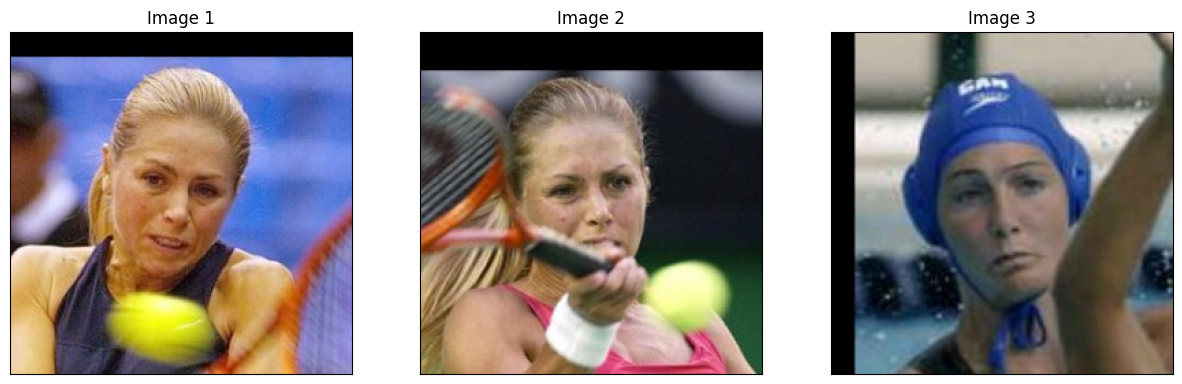

13233


In [6]:
# Call the function to load images and display them
image_paths = load_and_display_images('datasets/lfw')

print(len(image_paths))

# Step 2: Setting up Facial Detection and Blurring Features

This parts sets up `dlib` for facial detection and defines the blurring function.

### Explanation:
1. **Mask Creation**: A mask is created to specify which area of the image will be blurred. Initially, the mask is entirely black (`0` values indicate no masking).
2. **Convex Hull**: Computes the convex hull of the specified points, which creates a minimal convex boundary that encloses all the points. This hull is used to define the area on the mask that will correspond to the facial feature to blur.
3. **Blurring and Masking**: First, we apply a Gaussian blur to the entire image. It then uses the mask to combine the blurred version of the feature area with the original image. The mask ensures that only the specified feature region is blurred, leaving the rest of the image unaffected.
4. **Bitwise Operations**: `cv2.bitwise-and` and `cv2.bitwise_not` are used to isolate and the merge the blurred and non-blurred parts of the image. This approach ensures that the blurring effect is cleanly applied only to the desired facial feature.

In [7]:
def download_dlib_model(url, bz2_filename, dat_filename, remove_file = False):
    # Check if the decompressed .dat file already exists
    if not os.path.isfile(dat_filename):
        # Check if the compressed .bz2 file already exists
        if not os.path.isfile(bz2_filename):
            print(f"Downloading {bz2_filename}...")
            urllib.request.urlretrieve(url, bz2_filename)
            print(f"Downloaded {bz2_filename}.")

        # Decompress the .bz2 file to get the .dat file
        print(f"Decompressing {bz2_filename} to get {dat_filename}...")
        with bz2.BZ2File(bz2_filename, 'rb') as f_in:
            with open(dat_filename, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        print(f"Decompressed to {dat_filename}.")

        # Optionally, remove the .bz2 file after decompression
        if remove_file:
          os.remove(bz2_filename)
          print(f"Removed compressed file {bz2_filename}.")
    else:
        print(f"{dat_filename} already exists. No download needed.")

# URL to the dlib pre-trained facial landmark predictor
dlib_model_url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
# Filename of the compressed model
compressed_file_name = "shape_predictor_68_face_landmarks.dat.bz2"
# Filename of the decompressed model
model_file_name = "shape_predictor_68_face_landmarks.dat"

# Call the function to download and decompress the model
download_dlib_model(dlib_model_url, compressed_file_name, model_file_name)

Downloaded shape_predictor_68_face_landmarks.dat.bz2.
Decompressing shape_predictor_68_face_landmarks.dat.bz2 to get shape_predictor_68_face_landmarks.dat...
Decompressed to shape_predictor_68_face_landmarks.dat.


In [8]:
# Load the pre-trained face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
# Path to the facial landmark predictor
predictor_path = 'shape_predictor_68_face_landmarks.dat' # have to download this file
# Load the facial landmark predictor
predictor = dlib.shape_predictor(predictor_path)

import numpy as np
import cv2

def blur_feature(image, landmarks, feature_indices, feature_type):
    '''
    Applies a blurring effect to specific features on the face by fitting an ellipse around the landmarks.

    Parameters:
    image (numpy.ndarray): The original image.
    landmarks (dlib.full_object_detection): Facial landmarks detected by dlib predictor.
    feature_indices (list of int): Indices of the landmarks that define the region to blur.
    feature_type (str): The type of feature to blur ('eyes', 'nose', 'mouth').

    Returns:
    numpy.ndarray: The image with the specified feature blurred.
    '''

    # Create a mask to match the image dimensions, single channel for grayscale
    mask = np.zeros_like(image[:, :, 0])

    # Collect points from the landmarks based on the provided indices
    feature_points = np.array([(landmarks.part(n).x, landmarks.part(n).y) for n in feature_indices], dtype=np.int32)

    # Generate a convex hull (the smallest convex polygon containing all points) for the feature
    hull = cv2.convexHull(feature_points)

    # Fit a rotated rectangle to the convex hull of the feature points, which provides a better fit than an ellipse
    rect = cv2.minAreaRect(hull)
    box = cv2.boxPoints(rect)
    box = np.int32(box)

    # Depending on the feature, adjust the box dimensions
    if feature_type in ['eyes', 'mouth']:
        # For the eyes and mouth, expand the box horizontally
        center, size, angle = rect
        size = (size[0] * 1.4, size[1] * 1.2)  # Increase the size a bit for better coverage
        rect = (center, size, angle)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

    elif feature_type == 'nose':
        # For the nose, expand the box vertically
        center, size, angle = rect
        size = (size[0] * 1.2, size[1] * 1.4)
        rect = (center, size, angle)
        box = cv2.boxPoints(rect)
        box = np.int32(box)

    # Draw the fitted box on the mask
    cv2.drawContours(mask, [box], 0, (255, 255, 255), -1)

    # Apply Gaussian blur to the image
    blurred_image = cv2.GaussianBlur(image, (51, 51), 0)

    # Combine the original and blurred images using the mask
    combined_image = np.where(mask[..., None].astype(bool), blurred_image, image)

    return combined_image

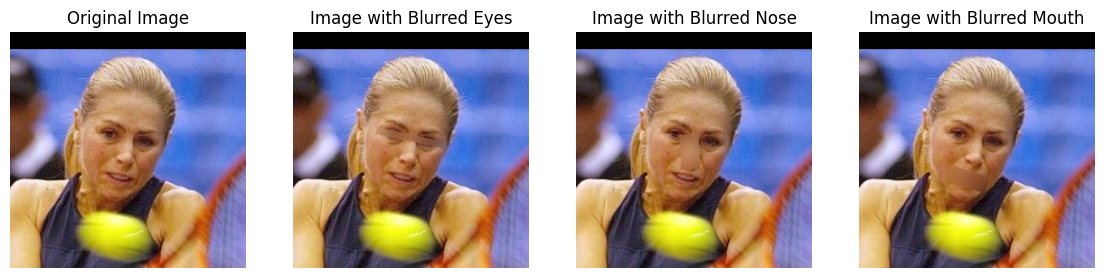

In [9]:
# Load the pre-trained face detector and facial landmark predictor
detector = dlib.get_frontal_face_detector()
predictor_path = 'shape_predictor_68_face_landmarks.dat'  # Path to the facial landmark predictor file
predictor = dlib.shape_predictor(predictor_path)  # Load the facial landmark predictor

# Assuming image_paths is already defined and contains paths to the images
selected_image_path = image_paths[0]  # Take the first image for demonstration
image = cv2.imread(selected_image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Detect faces in the image
faces = detector(gray)
for face in faces:
    landmarks = predictor(gray, face)

    # Example feature indices for the eyes (left and right)
    eyes_indices = list(range(36, 42)) + list(range(42, 48))
    nose_indices = list(range(27, 36))
    mouth_indices = list(range(48, 68))

    # Blur the eyes in the image
    image_with_blurred_eyes = blur_feature(image.copy(), landmarks, eyes_indices, 'eyes')
    # Blur the nose in the image
    image_with_blurred_nose = blur_feature(image.copy(), landmarks, nose_indices, 'nose')
    #Blur the mouth in the image
    image_with_blurred_mouth = blur_feature(image.copy(), landmarks, mouth_indices, 'mouth')

    # Convert from BGR to RGB for displaying
    original_image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    blurred_eyes_image_rgb = cv2.cvtColor(image_with_blurred_eyes, cv2.COLOR_BGR2RGB) # for eyes
    blurred_nose_image_rgb = cv2.cvtColor(image_with_blurred_nose, cv2.COLOR_BGR2RGB) # for nose
    blurred_mouth_image_rgb = cv2.cvtColor(image_with_blurred_mouth, cv2.COLOR_BGR2RGB) # for mouth

    # Display the original and blurred images side by side
    plt.figure(figsize=(14, 12))

    # Display original image
    plt.subplot(1, 4, 1)
    plt.imshow(original_image_rgb)
    plt.title('Original Image')
    plt.axis('off')

    # Display image with blurred eyes
    plt.subplot(1, 4, 2)
    plt.imshow(blurred_eyes_image_rgb)
    plt.title('Image with Blurred Eyes')
    plt.axis('off')

    # Display image with blurred nose
    plt.subplot(1, 4, 3)
    plt.imshow(blurred_nose_image_rgb)
    plt.title('Image with Blurred Nose')
    plt.axis('off')

    # Display image with blurred mouth
    plt.subplot(1, 4, 4)
    plt.imshow(blurred_mouth_image_rgb)
    plt.title('Image with Blurred Mouth')
    plt.axis('off')

    plt.show()
    break  # Only process the first face found for demonstration purposes

# Step 3: Processing Images to Create Modified Datasets

This part processes each image to blur specific facial features.

In [27]:
## RUN WITH CAUTION ##
def delete_non_empty_directory(dir_path, delete = False):
    if delete:
      # Check if the directory exists
      if os.path.exists(dir_path):
        # Remove the directory and all its contents
        shutil.rmtree(dir_path)
        print(f"Directory '{dir_path}' has been removed along with all its contents.")
      else:
        print(f"The directory '{dir_path}' does not exist.")
    else:
      print('No directory deleted.')

# Usage
directory_to_delete = "datasets/blurred_eyes"
delete_non_empty_directory(directory_to_delete, True)

directory_to_delete = "datasets/blurred_nose"
delete_non_empty_directory(directory_to_delete, True)

directory_to_delete = "datasets/blurred_mouth"
delete_non_empty_directory(directory_to_delete, True)

directory_to_delete = "datasets/normal"
delete_non_empty_directory(directory_to_delete, True)

Directory 'datasets/blurred_eyes' has been removed along with all its contents.
Directory 'datasets/blurred_nose' has been removed along with all its contents.
Directory 'datasets/blurred_mouth' has been removed along with all its contents.
Directory 'datasets/normal' has been removed along with all its contents.


In [ ]:
from skimage import io
detector = dlib.get_frontal_face_detector()
predictor_path = 'shape_predictor_68_face_landmarks.dat'  # Path to the facial landmark predictor file
predictor = dlib.shape_predictor(predictor_path)  # Load the facial landmark predictor

# Function to save an image
def save_image(image, path, filename):
    if not os.path.exists(path):
        os.makedirs(path)
    cv2.imwrite(os.path.join(path, filename), image)

# Function to create and save datasets with blurred features
def create_and_save_blurred_datasets(base_path, save_path):
    # Labels for face detected (1) and no face detected (-1)
    labels = {'normal': [], 'blurred_eyes': [], 'blurred_nose': [], 'blurred_mouth': []}

    # Loop over each individual in the LFW dataset
    for individual in os.listdir(os.path.join(base_path, 'lfw')):
        individual_path = os.path.join(base_path, 'lfw', individual)

        for image_file in os.listdir(individual_path):
            if image_file.lower().endswith('.jpg'):
                image_path = os.path.join(individual_path, image_file)
                image = io.imread(image_path)
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

                # Detect faces
                faces = detector(gray, 1)

                # Check if a face is detected
                if len(faces) > 0:
                    face_detected = True
                    face = faces[0]  # Only process the first detected face
                    landmarks = predictor(gray, face)

                    # Define landmark indices for features
                    eyes_indices = list(range(36, 42)) + list(range(42, 48))
                    nose_indices = list(range(27, 36))
                    mouth_indices = list(range(48, 68))

                    # Blur the features
                    blurred_eyes = blur_feature(image.copy(), landmarks, eyes_indices, 'eyes')
                    blurred_nose = blur_feature(image.copy(), landmarks, nose_indices, 'nose')
                    blurred_mouth = blur_feature(image.copy(), landmarks, mouth_indices, 'mouth')
                else:
                    face_detected = False
                    # Use the original image for all categories if no face is detected
                    blurred_eyes = image.copy()
                    blurred_nose = image.copy()
                    blurred_mouth = image.copy()

                # Save images and labels to disk
                save_image(image, os.path.join(save_path, 'normal'), image_file)
                save_image(blurred_eyes, os.path.join(save_path, 'blurred_eyes'), image_file)
                save_image(blurred_nose, os.path.join(save_path, 'blurred_nose'), image_file)
                save_image(blurred_mouth, os.path.join(save_path, 'blurred_mouth'), image_file)

                # Assign labels: 1 for face detected, -1 for no face detected
                face_label = 1 if face_detected else -1
                labels['normal'].append(face_label)
                labels['blurred_eyes'].append(face_label)
                labels['blurred_nose'].append(face_label)
                labels['blurred_mouth'].append(face_label)

    # Save labels to a file for each dataset
    for key in labels:
        labels_path = os.path.join(save_path, key)
        if not os.path.exists(labels_path):
            os.makedirs(labels_path)
        np.save(os.path.join(labels_path, f'labels.npy'), np.array(labels[key]))

# Create and save the datasets
dataset_base_path = 'datasets'  # Base path to the LFW dataset
save_dataset_path = 'datasets'  # Path where you want to save the new datasets

create_and_save_blurred_datasets(dataset_base_path, save_dataset_path)

In [11]:
# Directory of the dataset and output directories
data_dir = 'datasets/lfw' # Path where the original dataset is stored
output_dirs = {
    'eyes': 'datasets/blurred_eyes', # Directory to store images with blurred eyes
    'nose': 'datasets/blurred_nose',  # Directory to store images with blurred nose
    'mouth': 'datasets/blurred_mouth' # Director to store images with blurred mouth
}

# Create the output directories if they do not exist
for path in output_dirs.values():
    os.makedirs(path, exist_ok=True)

# Define the landmark indices for each facial feature based on the 68-point model
feature_indices = {
    'eyes': list(range(36, 42)) + list(range(42, 48)), # Indices for left and right eyes
    'nose': list(range(27, 36)), # Indices for the nose
    'mouth': list(range(48, 68)) # Indices for the mouth
}

# Process each image using paths from image_paths
for image_path in image_paths:
    image = cv2.imread(image_path) # Read the image
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) # Convert the image to grayscale for detection

    # Detect faces in the image
    faces = detector(gray)
    for face in faces:
        landmarks = predictor(gray, face) # Detect landmarks for each face

        # Process each defined feature (eyes, nose, mouth)
        for feature, indices in feature_indices.items():
            # Blur the specific feature on the image
            modified_image = blur_feature(image.copy(), landmarks, indices, feature)
            # Define the output path for the blurred image
            output_dir = output_dirs[feature]
            os.makedirs(output_dir, exist_ok=True)  # Ensure output directory exists
            output_path = os.path.join(output_dir, os.path.basename(image_path))
            # Save the modified image to the appropriate directory
            cv2.imwrite(output_path, modified_image)

print("Modified datasets created.")

Modified datasets created.


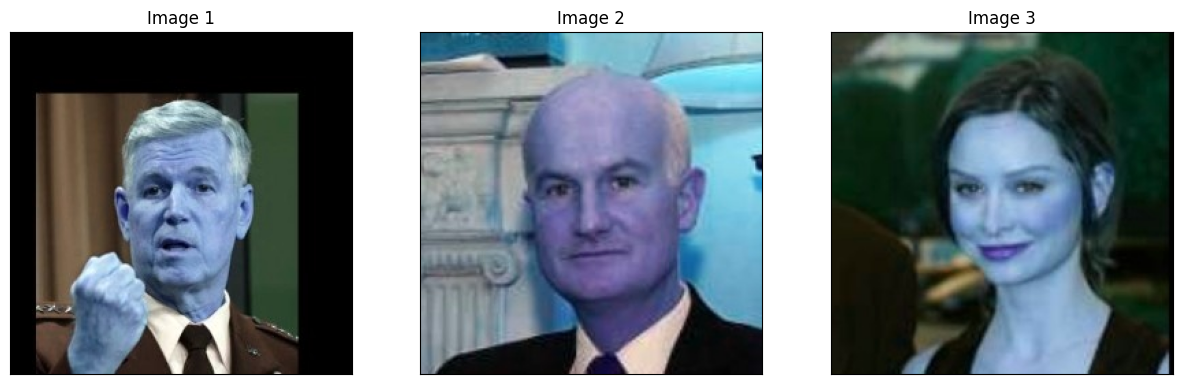

0


In [9]:
# Load and display for normal images
normal_paths = load_and_display_images('datasets/normal')
print(len(normal_paths) - len(image_paths))

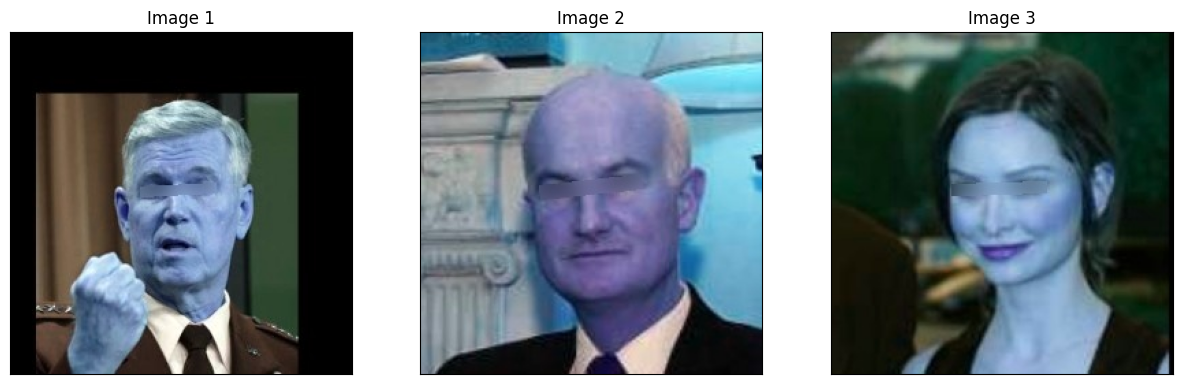

0


In [10]:
# Load and display image for blurred eyes
blurred_eyes_paths = load_and_display_images('datasets/blurred_eyes')
print(len(blurred_eyes_paths) - len(image_paths))

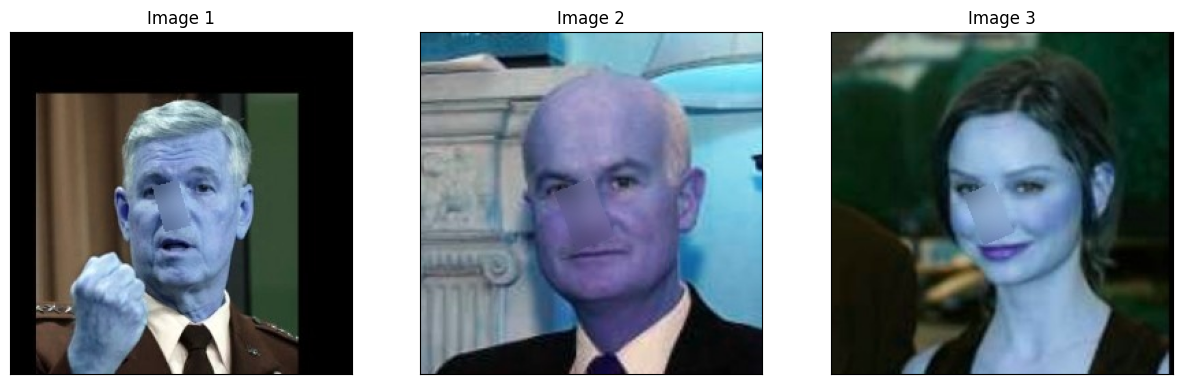

0


In [11]:
# Load and display image for blurred nose
blurred_nose_paths = load_and_display_images('datasets/blurred_nose')
print(len(blurred_nose_paths) - len(image_paths))

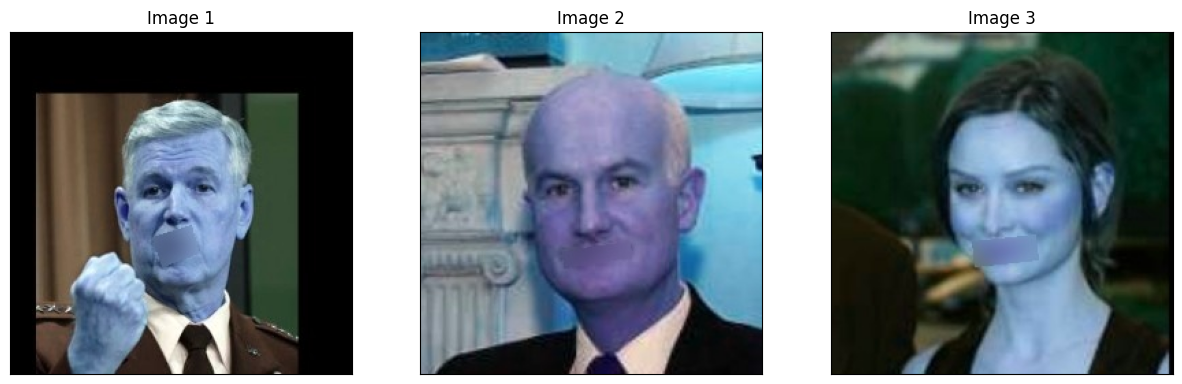

0


In [12]:
# Load and display image for blurred mouth
blurred_mouth_paths = load_and_display_images('datasets/blurred_mouth')
print(len(blurred_mouth_paths) - len(image_paths))

# PART 2: Building Face Detection Model

In [20]:
!pip uninstall keras
!pip install keras==2.12
!pip install git+https://github.com/rcmalli/keras-vggface.git

Found existing installation: keras 2.15.0
Uninstalling keras-2.15.0:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-2.15.0.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? Y
  Successfully uninstalled keras-2.15.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 9.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 2.12.0 which is incompatible.


  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-s4tq_uts
  Running command git clone --filter=blob:none --quiet https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-s4tq_uts
  Resolved https://github.com/rcmalli/keras-vggface.git to commit bee35376e76e35d00aeec503f2f242611a97b38a
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 572, in _determine_conflicts
    retu

In [2]:
!pip install keras_applications --no-deps
filename = "/usr/local/lib/python3.10/dist-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))
import tensorflow as tf

In [4]:
# Import required librabries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras.layers import Input, Dense, Flatten, Reshape, Dropout, Conv2DTranspose
from keras.models import Model
from keras.optimizers import Adam
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Step 1: Load and Prepare the data

In [5]:
import os

def load_and_split_data(save_path, dataset_type, paths, test_size=0.2):
    # Load and resize images
    images = []
    for path in paths:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, (224, 224))  # Resize the image
            images.append(img)
    images = np.array(images, dtype='float32') / 255.0  # Normalize the images

    # Load labels
    labels_path = os.path.join(save_path, dataset_type, 'labels.npy')
    labels = np.load(labels_path)[:len(images)]  # Ensure labels match the number of loaded images

    # Print the number of images and labels
    print(f"Number of images: {len(images)}")
    print(f"Number of labels: {len(labels)}")

    # Check if the number of images matches the number of labels
    if len(images) != len(labels):
        raise ValueError("The number of images and labels must match.")

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        images, labels, test_size=test_size, random_state=42)

    return X_train, X_test, y_train, y_test

In [21]:

print(blurred_eyes_paths)

['datasets/blurred_eyes/Richard_Myers_0015.jpg', 'datasets/blurred_eyes/Michael_Peat_0001.jpg', 'datasets/blurred_eyes/Calista_Flockhart_0005.jpg', 'datasets/blurred_eyes/Daniel_Darnell_0001.jpg', 'datasets/blurred_eyes/Paul_Martin_0003.jpg', 'datasets/blurred_eyes/Michael_J_Sheehan_0002.jpg', 'datasets/blurred_eyes/Craig_Wilson_0001.jpg', 'datasets/blurred_eyes/Lionel_Richie_0002.jpg', 'datasets/blurred_eyes/Oracene_Williams_0001.jpg', 'datasets/blurred_eyes/Didier_Defago_0001.jpg', 'datasets/blurred_eyes/David_Millar_0001.jpg', 'datasets/blurred_eyes/Bill_Graham_0007.jpg', 'datasets/blurred_eyes/Juan_Carlos_0001.jpg', 'datasets/blurred_eyes/Richard_Greenberg_0001.jpg', 'datasets/blurred_eyes/Lenny_Wilkens_0003.jpg', 'datasets/blurred_eyes/Vladimir_Putin_0001.jpg', 'datasets/blurred_eyes/Celine_Dion_0004.jpg', 'datasets/blurred_eyes/George_W_Bush_0507.jpg', 'datasets/blurred_eyes/William_Morrow_0001.jpg', 'datasets/blurred_eyes/George_W_Bush_0143.jpg', 'datasets/blurred_eyes/Aitor_Gon

In [1]:
# # for normal
# X_train_normal = train_test_data['normal']['X_train']
# X_test_normal = train_test_data['normal']['X_test']
# y_train_normal = train_test_data['normal']['y_train']
# y_test_normal = train_test_data['normal']['y_test']

# # for blurred eyes
# X_train_eyes = train_test_data['blurred_eyes']['X_train']
# X_test_eyes = train_test_data['blurred_eyes']['X_test']
# y_train_eyes = train_test_data['blurred_eyes']['y_train']
# y_test_eyes = train_test_data['blurred_eyes']['y_test']

# # for blurred nose
# X_train_nose = train_test_data['blurred_nose']['X_train']
# X_test_nose = train_test_data['blurred_nose']['X_test']
# y_train_nose = train_test_data['blurred_nose']['y_train']
# y_test_nose = train_test_data['blurred_nose']['y_test']

# # for blurred mouth
# X_train_mouth = train_test_data['blurred_mouth']['X_train']
# X_test_mouth = train_test_data['blurred_mouth']['X_test']
# y_train_mouth = train_test_data['blurred_mouth']['y_train']
# y_test_mouth = train_test_data['blurred_mouth']['y_test']

NameError: name 'train_test_data' is not defined

In [13]:
# Define paths
save_dataset_path = 'datasets'  # Path where you have saved the new datasets

X_train_normal, X_test_normal, y_train_normal, y_test_normal = load_and_split_data(save_dataset_path, 'normal', normal_paths[:5000]) # just use the
#X_train_eyes, X_test_eyes, y_train_eyes, y_test_eyes = load_and_split_data(save_dataset_path, 'blurred_eyes', blurred_eyes_paths)
#X_train_nose, X_test_nose, y_train_nose, y_test_nose = load_and_split_data(save_dataset_path, 'blurred_nose', blurred_nose_paths)
#X_train_mouth, X_test_mouth, y_train_mouth, y_test_mouth = load_and_split_data(save_dataset_path, 'blurred_mouth', blurred_mouth_paths)

Number of images: 5000
Number of labels: 5000


In [14]:
print(len(X_train_normal), len(y_train_normal), len(X_test_normal), len(y_test_normal))
print(len(X_train_normal[0][0]), y_train_normal[0])

4000 4000 1000 1000
224 1


# Understanding CNNs for Face Detection
To set up a convolutional neural network (CNN) specifically for face detection, we can build a model that learns the presence of a face in an image and possibly localize it.

For face detection, we typically use a CNN to process the image through multiple connvolutional layers that learn to extract increasingly complex features. At the simplest level, early layers might detect edges and textures, while deeper layers might identify parts of faces like eyes, nose, and mouth. The final layers would then integrate this information to decide whether a face is present.

## How CNN Simulates Neurons for Face Feature Dectection
In the brain, different neurons are sensitive to different visual stimuli, such as edges, shapes and textures. In a similar way, each filter in a CNN layer can be thought of as detecting different features from its input:

1. Early layers: Detect simple features like edges and colors. These are anagolous to the early visual areas, such as V1.
2. Middle layers: Begin to assemble these simple features into more complex combinations, such as textures and parts of objects (like eyes, nose, and mouth in the context of faces).
3. Deeper layers: Integrate the complex features to recognize higher-level patterns, such as entire faces.


---



# Step 2: Setting up the Model

In [19]:
from keras.layers import BatchNormalization

def build_model():
  # Load the VGGFace model with RestNet50 architecture
  base_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

  # Adding custom layers
  x = base_model.output
  x = Flatten()(x)
  x = Dense(512, activation='relu')(x)
  x = Dropout(0.5)(x)
  x = BatchNormalization()(x)
  predictions = Dense(1, activation='sigmoid')(x)

  # Creating the final model
  model = Model(inputs=base_model.input, outputs=predictions)

  # Compile the model
  model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
  return model

In [20]:
face_detector = build_model()

# Code Explanation
1. Load VGGFace with ResNet50 Architecture
```python
base_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
```
- What it does: This line loads a pre-trained VGGFace model using the ResNet50 architecture. `include_top=False` removes the top (or the last fully connected) layers of the network, making it adaptable for new tasks. The input_shape specifies the expected input size of the images (224x224 pixels with 3 color channels). `pooling='avg'` applies global average pooling to the output of the final convolutional layer, reducing its spatial dimensions to 1x1 per filter, which helps in reducing the model size and computation.
- Brain analogy: This part of the model simulates the early to intermediate stages of visual processing in the human brain where different areas (like V1, V2, and beyond in the visual cortex) process visual stimuli to detect simple to complex features. In the context of face detection, this can be akin to detecting features like contours, textures, and parts of the face.

2. Flatten the Output
```python
x = Flatten()(x)
```
- What it does: This layer converts the pooled feature maps into a single long vector. It prepares the high-level features extracted by the convolutional layers for classification.
- Brain analogy:  Flattening can be thought of as preparing the integrated visual signals for further cognitive processing, similar to how the brain might organize and streamline information for decision-making.

3. Dense Layer with ReLU activation
```python
x = Dense(512, activation='relu')(x)
```
- What it does: This fully connected layer takes the flattened input and transforms it through 512 neurons, applying the rectified linear unit (ReLU) activation function. This layer allows the network to learn non-linear combinations of the high-level features extracted by the convolutional layers.
- Brain analogy: This layer could simulate the deeper cognitive processes where the brain integrates different facial features and contextual information to recognize faces. Neurons in this layer could be akin to neurons in the fusiform face area (FFA), a part of the human brain known to specialize in facial recognition.

4. Dropout for Regularization
```python
x = Dropout(0.5)(x)
```
- What it does:  Dropout is a regularization technique where randomly selected neurons are ignored during training, reducing the risk of overfitting. This helps make the model robust to unseen data by preventing it from relying too heavily on any individual neuron.
- Brain analogy: This might mimic how the brain deals with uncertainty and noise by not relying on a single pathway or signal for recognizing faces, thus enhancing the robustness of facial recognition capabilities under different conditions.

5. Output layer for Binary Classification
```python
predictions = Dense(1, activation='sigmoid')(x)
```
- What it does: This layer maps the features learned by the network to a single sigmoid unit, which outputs a probability indicating the presence or absence of a face in the input image.
- Brain analogy: This is similar to the decision-making process in the brain where, after processing and integrating all relevant information, a conclusion is drawn about whether a face is present.

---

# Step 3: Train the Model

In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Setup callbacks
checkpoint = ModelCheckpoint("best_model.h5", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

# Fit the model
history = face_detector.fit(
    X_train_normal, y_train_normal,
    epochs=10,
    batch_size=32,
    validation_split=0.2,
    callbacks=[checkpoint, earlystopping]
)

Epoch 1/10
 46/100 [============>.................] - ETA: 17:39 - loss: 0.5730 - accuracy: 0.7643

# Step 4: Evaluate the model

32/32 [==============================] - 150s 4s/step
Accuracy: 0.988, Precision: 0.988, Recall: 1.0, F1-score: 0.993963782696177


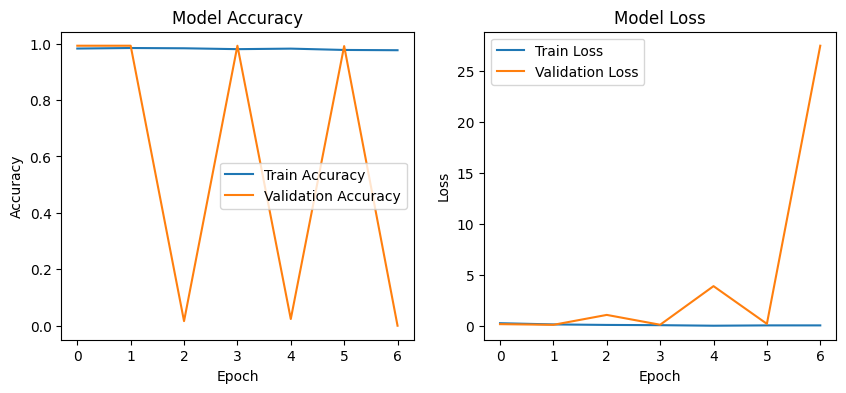

In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import load_model

# Load the best model
model = load_model("best_model.h5")

# Predictions
predictions = model.predict(X_test_normal)
predictions = (predictions > 0.5).astype(int)

# Metrics
accuracy = accuracy_score(y_test_normal, predictions)
precision = precision_score(y_test_normal, predictions)
recall = recall_score(y_test_normal, predictions)
f1 = f1_score(y_test_normal, predictions)

print(f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1-score: {f1}")

# Plotting
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


# Part 3: Simulating Neurological Deficit
To simulate a neurological deficit in a neural network where the systems struggle to detect specific facial features like eyes, nose and mouth, you can modify the model in a way that impairs its ability to recognize these features. This approach is akin to simulating conditions such as prosopagnia (face blindness) or certain types of agnosia that affect facial feature recognition.

## Strategies to mimic neurological deficits:
#### 1. Selective Input Masking or Distortion
One effective approach is to directly modify the input data by masking or distorting facial features. This simulates conditions where the brain fails to prcoess certain types of visual information.

**Implementation:**
- Use image processing techniques to blur or mask teh eyes, nose, and mouth regions in the training and validation images
- We can identify these regions using facial landmark detection using `dlib` or `OpenCV` and apply transformations like blurring or blacking out these areas.

#### 2. Impairment of Feature-Extraction Layers
Another approach imvolves impairing the neural network's layers that are responsible for extracting and processing facial features associated with eyes, nose and mouth.

**Implementation:**
- Introduce dropout or noise specifically in the middle layers of the network, which are crucial for detecting integrating complex features like facial components.
- Customize the dropout or noise layers to activate only during the processing of relevant features, possibly by using conditional activation based on the feature maps that correlate strongly with facial features.


#### 3. Reduction of Learning Capacity in Specific Layers
Reduce the learning capacity of the network in the layers that typically learn to recognize these features. This can be done by reducing the number of neurons or channels in specific convolutional layers or freezing the weights of these layers after initializing them in a way that they are less effective.

**Implementation:**
- Identify the layers most resposible for facial feature detection - often the initial to middle convolutional layers in CNN
- Modify these layers by reducing their complexity or by applying regularizations that impair their effectiveness.

---


# Approach 1: Selective Input Masking or Distortion

- Datasets are already created, so we just test the model on the original trained model.

In [ ]:
# Code to test the model on blurred_eyes, blurred_nose and blurred_mouth

# Approach 2: Impairment with Feature Extraction with Dropout

In [ ]:
from keras_vggface.vggface import VGGFace
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout, Conv2D, Lambda
import keras.backend as K

def add_selective_dropout(layer, rate=0.5):
    # Function to add dropout selectively based on layer activation
    def dropout_layer(x):
        return K.dropout(x, level=rate)
    return Lambda(dropout_layer)(layer)

def build_model_with_selective_dropout():
    base_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    # Set specific layers to have dropout
    layer_outputs = [layer.output for layer in base_model.layers]
    dropout_layers = [10, 40, 100]  # Example layers where you want to add dropout

    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Adding selective dropout in specified layers
    for i, layer_output in enumerate(layer_outputs):
        if i in dropout_layers:
            layer_output = add_selective_dropout(layer_output, rate=0.5)

    predictions = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model
model_with_dropout = build_model_with_selective_dropout()

# Approach 3: Reduction of Learning Capacty in Specific Layers

In [ ]:
def build_model_with_reduced_capacity():
    base_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    # Identify layers to reduce capacity or freeze
    for layer in base_model.layers:
        if 'conv5' in layer.name:  # Example to target deeper layers
            # Freeze layers
            layer.trainable = False

            # Alternatively, reduce the number of filters if creating a new layer setup
            # e.g., replacing a Conv2D layer with fewer filters

    x = base_model.output
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)  # Reduced number of neurons
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Create the model with reduced capacity
model_with_reduced_capacity = build_model_with_reduced_capacity()

# Simulating Prosopagnosia in a ConvNet

To simulate prosopagnosia (commonly known as face blindness) in a ConvNet like VGGFace wirth ResNet50 architecture, we need to impair the model's ability to recognize or identify faces as a whole, rather than just specific facial featurs. Prosopagnosia affects a person's ability to recognize familiar faces, even though the ability to recognize other objects may remain intact.

Steps to modify the network:
1. Global Feature Integration Impairment: Prosopagnosia could be simulated by disrupting the integration of global facial features. This can be done by introducing modifications that impair the model's ability to consolidate information across the entire face. This can be done by applying dropout layers to the deeper, full connected layers or the last few convolutional layers.

2. Noise Injection: Simulate the neurological deficit by injecting noise into the deeper layers of the network. affecting how features are integrated and interpreted.

3. Disabling Critical Pathways: In this approach, we disable or "freeze" certain critical pathways that are essential for face recognition. This can be done by freezing weights in key layers.

---


## Approach 1: Global Feature Impairment

In [ ]:
def build_prosopagnosia_model():
    base_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    x = base_model.output

    # Apply global average pooling followed by dropout
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Higher dropout to simulate integration impairment

    # Output layer
    predictions = Dense(1, activation='sigmoid')(x)  # Assuming binary classification for face/non-face

    # Create and compile the model
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
pro_dropout_model = build_prosopagnosia_model()

## Approach 2: Noise Injection

In [ ]:
def build_prosopagnosia_model_with_noise():
    base_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = GaussianNoise(0.1)(x)  # Inject noise to simulate neurological deficits

    # Output layer
    predictions = Dense(1, activation='sigmoid')(x)

    # Create and compile the model
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
pro_noise_model = build_prosopagnosia_model_with_noise()

## Approach 3: Disabling Critical Pathways

In [ ]:
def build_frozen_feature_model():
    base_model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')

    # Freeze specific layers
    for layer in base_model.layers[-10:]:  # Freeze the last 10 layers
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)

    # Output layer
    predictions = Dense(1, activation='sigmoid')(x)

    # Create and compile the model
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
pro_frozen_model = build_frozen_feature_model()

# Train the models

In [ ]:
def train_model(model, X_train, y_train, X_val, y_val):
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=5,  # You may adjust this number based on your convergence observations
        batch_size=32,
        verbose=1)
    return history

# Example datasets
# Ensure your datasets X_train, y_train, X_val, y_val are correctly loaded and preprocessed.

# Training the dropout model
history_dropout = train_model(pro_dropout_model , X_train_normal, y_train_normal, X_test_normal, y_test_normal)

# Training the noise injection model
history_noise = train_model(pro_noise_model, X_train_normal, y_train_normal, X_test_normal, y_test_normal)

# Training the frozen feature model
history_frozen = train_model(pro_frozen_model, X_train_normal, y_train_normal, X_test_normal, y_test_normal)


In [ ]:
## Evluatte the model
def evaluate_model(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)  # Assuming binary classification and sigmoid activation

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    return accuracy, precision, recall, f1

In [ ]:
# Evaluate each model
dropout_metrics = evaluate_model(pro_dropout_model, X_test_normal, y_test_normal)
noise_metrics = evaluate_model(pro_noise_model, X_test_normal, y_test_normal)
frozen_metrics = evaluate_model(pro_frozen_model, X_test_normal, y_test_normal)

print("Dropout Model Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(*dropout_metrics))
print("Noise Model Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(*noise_metrics))
print("Frozen Model Metrics: Accuracy: {:.4f}, Precision: {:.4f}, Recall: {:.4f}, F1-score: {:.4f}".format(*frozen_metrics))


In [ ]:
def plot_accuracy(history, title='Model Accuracy'):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [ ]:
plot_accuracy(history_dropout, 'Dropout Model Accuracy')

In [ ]:
plot_accuracy(history_noise, 'Noise Model Accuracy')

In [ ]:
plot_accuracy(history_frozen, 'Frozen Features Model Accuracy')